In [1]:
import numpy as np
import torch
from pathlib import Path
from pyro.distributions import Normal
import os
from bnn_priors.models import DenseNet
from bnn_priors.inference import SGLD
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
data = np.load("../data/snelson.npz")

model = DenseNet(1,1,32)
if torch.cuda.is_available():
    model = model.cuda()

x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(model.lin1.weight)
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

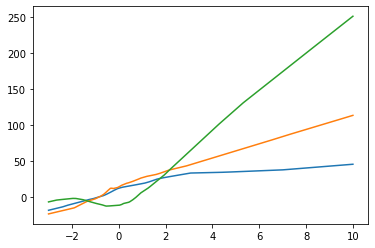

In [3]:
with torch.no_grad():
    for _ in range(3):
        model.sample_all_priors()
        y = model(x_test).loc.cpu()
        plt.plot(x_test.cpu(), y)

In [144]:
N_steps = 10
skip = 50
warmup = 500
cycles = 5
temperature = 1.0

model = DenseNet(1,1,32)
if torch.cuda.is_available():
    model = model.cuda()   # Resample model with He initialization so SGLD works.

sgld = SGLD(model=model, num_samples=N_steps, warmup_steps=warmup, learning_rate=1e-4,
            skip=skip, sampling_decay=True, cycles=cycles, temperature=temperature)
sgld.run(x=x_train, y=y_train, progressbar=True)

samples = sgld.get_samples()

Sampling: 100%|██████████| 500/500 [00:01<00:00, 250.56it/s]


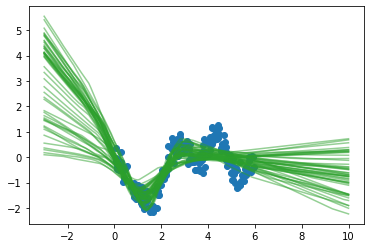

In [145]:
for i in range(cycles*N_steps):
    param_sample = {param : value[i] for param, value in samples.items()}
    model.load_state_dict(param_sample)
    with torch.no_grad():
        plt.plot(x_test.cpu(), model(x_test).loc.cpu(), color="C2", alpha=0.5)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()